In [43]:
import pickle
import numpy as np
import sys
sys.path.insert(0, '/home/abrahamn/21cmIRxcor/')
import cat_utils

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io.votable import parse
from astropy.table import Table

In [44]:
d = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57639/whole_field/'
sefluxname = 'best'
secat = pickle.load( open(d+'whole_field_secat_'+sefluxname+'.p', "rb" ) )
g = secat.jy>1.e-10
secat = cat_utils.Catalog(secat.ra[g],secat.dec[g],secat.jy[g])

In [45]:
# apass cat
apasscatdat = np.genfromtxt('/home/abrahamn/xcor_data/ir_catalogs/apass_6degcat.csv',skip_header=2,delimiter=',')
has_iprime_mag = np.logical_not(np.isnan(apasscatdat[:,23]))
apass_cat = cat_utils.Catalog(apasscatdat[has_iprime_mag,2],apasscatdat[has_iprime_mag,3],3631.*10.**(-apasscatdat[has_iprime_mag,23]/2.5))

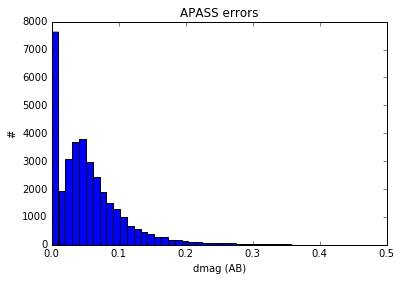

In [57]:
h = plt.hist(apasscatdat[has_iprime_mag,24],np.linspace(0,.5))
plt.xlabel('dmag (AB)')
plt.ylabel('#')
plt.title('APASS errors')

In [4]:
# dophot cat
dophot_cat = cat_utils.IRCatalog('/home/abrahamn/xcor_data/ATLAS_mwa57694_rereduction/02a57694o0281I.dph')
dophot_cat.ra = dophot_cat.ra_all
dophot_cat.dec = dophot_cat.dec_all
dophot_cat.jy = dophot_cat.jy_all

loading /home/abrahamn/xcor_data/ATLAS_mwa57694_rereduction/02a57694o0281I.dph


In [5]:
# plt.plot(dophot_cat.ra_all,dophot_cat.dec_all,'.')

In [6]:
# # to get early skymapper data, do a cone search through an australian proxy
# # http://skymapper.anu.edu.au.prx.teleport.to/edr_cone/query?RA=1&DEC=-29&SR=.35&VERB=2

# # need to edit the xml file and change datatypes "character(18)" and "character(3)" to "char"
# catdir = '/home/abrahamn/xcor_data/ir_catalogs/'
# skymappercat = parse(catdir + 'view-source_skymapper.anu.edu.au.prx.teleport.to_edr_cone_query_RA=1&DEC=-29&SR=.35&VERB=2.xml').get_first_table().array

In [7]:
# skymappercat.dtype

In [8]:
# # http://skymapper.anu.edu.au/table-browser/
# ra = skymappercat['raj2000']
# dec = skymappercat['dej2000']
# flags = skymappercat['flags']
# ab_mag_psf = skymappercat['i_psf'] # mag measured by psf fitting
# ab_mag_petro = skymappercat['i_petro'] # mag measured in an azimuthally averaged radius, see http://www.sdss.org/dr12/algorithms/magnitudes/#mag_petro

# jy_psf = 3631.*10.**(-ab_mag_psf/2.5)
# jy_petro = 3631.*10.**(-ab_mag_petro/2.5)

# skymapper_cat = cat_utils.Catalog(ra,dec,jy_psf)

In [9]:
# secat_bounded = secat.limit_to_ra_dec_min_max(np.min(ra),np.max(ra),np.min(dec),np.max(dec))
# dophot_cat_bounded = dophot_cat.limit_to_ra_dec_min_max(np.min(ra),np.max(ra),np.min(dec),np.max(dec))
# apass_cat_bounded = apass_cat.limit_to_ra_dec_min_max(np.min(ra),np.max(ra),np.min(dec),np.max(dec))

In [10]:
# plt.figure(figsize=(20,15))
# plt.scatter(ra,dec,25000*skymapper_cat.jy,edgecolor='none',facecolor='red')

# plt.scatter(secat_bounded.ra,secat_bounded.dec,25000*secat_bounded.jy,facecolor='none')
# plt.scatter(dophot_cat_bounded.ra,dophot_cat_bounded.dec,25000*dophot_cat_bounded.jy,facecolor='none',edgecolor='blue')

# plt.scatter(apass_cat_bounded.ra,apass_cat_bounded.dec,25000*apass_cat_bounded.jy,facecolor='none',edgecolor='cyan')

In [ ]:
# for each apass source, look for matching dophot and source extractor sources

indices_of_matching_sex_sources = np.zeros(len(apass_cat.jy),dtype=int)-1 # -1 if no match
indices_of_matching_dophot_sources = np.zeros(len(apass_cat.jy),dtype=int)-1 # -1 if no match
for i in range(len(apass_cat.jy)):
    if i % 100 == 0: print('%f'%(1.*i/len(apass_cat.jy)))
    asec_to_all_sex_sources = np.sqrt((apass_cat.dec[i]-secat.dec)**2+np.sin(apass_cat.dec[i]*np.pi/180)**2*(apass_cat.ra[i]-secat.ra)**2)*3600.
    if np.min(asec_to_all_sex_sources) < 1:
        indices_of_matching_sex_sources[i] = np.argmin(asec_to_all_sex_sources)
        
    asec_to_all_dophot_sources = np.sqrt((apass_cat.dec[i]-dophot_cat.dec)**2+np.sin(apass_cat.dec[i]*np.pi/180)**2*(apass_cat.ra[i]-dophot_cat.ra)**2)*3600.
    if np.min(asec_to_all_dophot_sources) < 1:
        indices_of_matching_dophot_sources[i] = np.argmin(asec_to_all_dophot_sources)

0.000000
0.002850
0.005700
0.008551
0.011401
0.014251
0.017101
0.019952
0.022802
0.025652
0.028502
0.031352
0.034203
0.037053
0.039903
0.042753
0.045604
0.048454
0.051304
0.054154
0.057004
0.059855
0.062705
0.065555
0.068405
0.071256
0.074106
0.076956
0.079806
0.082656
0.085507
0.088357
0.091207
0.094057
0.096908
0.099758
0.102608
0.105458
0.108308
0.111159
0.114009
0.116859
0.119709
0.122559
0.125410
0.128260
0.131110
0.133960
0.136811
0.139661
0.142511
0.145361
0.148211
0.151062
0.153912
0.156762
0.159612
0.162463
0.165313
0.168163
0.171013
0.173863
0.176714
0.179564
0.182414
0.185264
0.188115
0.190965
0.193815
0.196665
0.199515
0.202366
0.205216
0.208066
0.210916
0.213767
0.216617
0.219467
0.222317
0.225167
0.228018
0.230868
0.233718
0.236568
0.239419
0.242269
0.245119
0.247969
0.250819
0.253670
0.256520
0.259370
0.262220
0.265071
0.267921
0.270771
0.273621
0.276471
0.279322
0.282172
0.285022
0.287872
0.290723
0.293573
0.296423
0.299273
0.302123
0.304974
0.307824
0.310674
0.313524
0

In [19]:
def jy2mag(jy):
    return -2.5*np.log10(jy/3631.)

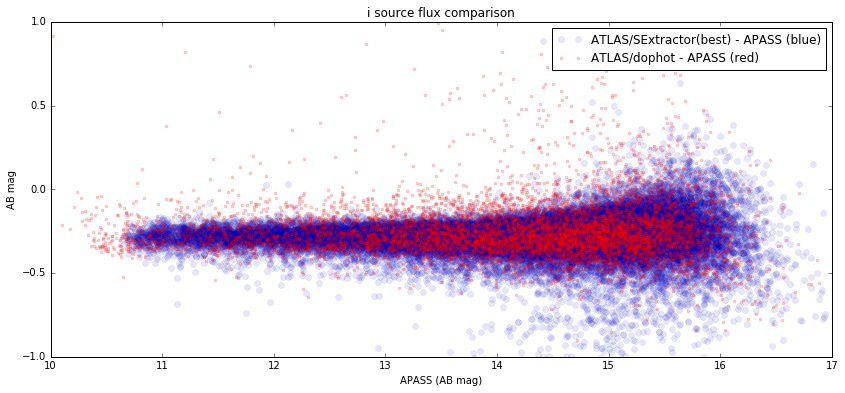

In [59]:
plt.figure(figsize=(14,6))

plt.plot(jy2mag(apass_cat.jy[indices_of_matching_sex_sources>0]),\
         jy2mag(secat.jy[indices_of_matching_sex_sources[indices_of_matching_sex_sources>0]])-jy2mag(apass_cat.jy[indices_of_matching_sex_sources>0]),'bo',\
         label='ATLAS/SExtractor('+sefluxname+') - APASS (blue)',alpha=.1)

plt.plot(jy2mag(apass_cat.jy[indices_of_matching_dophot_sources>0]),\
         jy2mag(dophot_cat.jy)[indices_of_matching_dophot_sources[indices_of_matching_dophot_sources>0]]-jy2mag(apass_cat.jy[indices_of_matching_dophot_sources>0]),'r.',\
         label='ATLAS/dophot - APASS (red)',alpha=.2)

plt.xlim([10,17])
plt.ylabel('AB mag')
plt.legend()
plt.ylim([-1,1])
plt.xlabel('APASS (AB mag)')
plt.title('i source flux comparison')

#plt.savefig('skymapper_vs_dophot_vs_se_'+sefluxname+'.png',bbox_inches='tight')

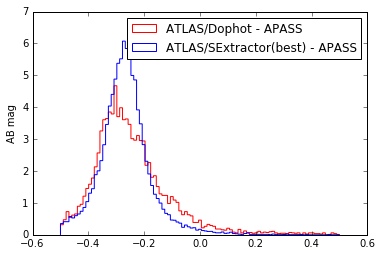

In [55]:
b = np.linspace(-.5,.5,100)

l1,l2 = 'ATLAS/Dophot - APASS','ATLAS/SExtractor(best) - APASS'
plt.ylabel('AB mag')

aa = plt.hist(jy2mag(dophot_cat.jy)[indices_of_matching_dophot_sources[indices_of_matching_dophot_sources>0]]-jy2mag(apass_cat.jy[indices_of_matching_dophot_sources>0]),b,histtype='step',normed=True,color='red',label=l1)
bb = plt.hist(jy2mag(secat.jy[indices_of_matching_sex_sources[indices_of_matching_sex_sources>0]])-jy2mag(apass_cat.jy[indices_of_matching_sex_sources>0]),b,histtype='step',normed=True,color='blue',label=l2)

plt.legend()